## First testing the API to ensure that it is working.
The [API Testing Script](https://github.com/brockwebb/acs-data-analyst-gpt/blob/main/Census-API-TestScript) is from the [ACS GPT Project Repository](https://github.com/brockwebb/acs-data-analyst-gpt/tree/main) on Github.

In [1]:
import requests
import pandas as pd

def test_census_api_2022(api_key):
    base_url = "https://api.census.gov/data/2022/acs/acs5"
    
    params = {
        "get": "NAME,B01001_001E",
        "for": "state:*",
        "key": api_key
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        data = response.json()
        
        print("Raw data (first 5 items):")
        print(data[:5])
        
        print("\nData type:", type(data))
        print("Length of data:", len(data))
        
        if len(data) > 1:
            print("\nLength of first row:", len(data[0]))
            print("Length of second row:", len(data[1]))
        
        # Manually create DataFrame without using numpy
        columns = data[0]
        rows = data[1:]
        df = pd.DataFrame(rows, columns=columns)
        
        # Convert population to numeric
        df['B01001_001E'] = pd.to_numeric(df['B01001_001E'])
        
        print("\nFirst few rows of data:")
        print(df.head())
        
        print(f"\nTotal number of states: {len(df)}")
        
        print("\nPopulation statistics:")
        print(df['B01001_001E'].describe())
        
        return True
    
    except requests.exceptions.RequestException as e:
        print(f"Error making request: {e}")
        return False
    except ValueError as e:
        print(f"Error parsing JSON response: {e}")
        return False
    except Exception as e:
        print(f"Unexpected error: {e}")
        print("Error type:", type(e))
        print("Error details:", str(e))
        return False

# Replace with your actual Census API key
api_key = # ---- KEY REDACTED ------ 

if __name__ == "__main__":
    if test_census_api_2022(api_key):
        print("\nCensus API test successful!")
    else:
        print("\nCensus API test failed.")

Raw data (first 5 items):
[['NAME', 'B01001_001E', 'state'], ['Alabama', '5028092', '01'], ['Alaska', '734821', '02'], ['Arizona', '7172282', '04'], ['Arkansas', '3018669', '05']]

Data type: <class 'list'>
Length of data: 53

Length of first row: 3
Length of second row: 3

First few rows of data:
         NAME  B01001_001E state
0     Alabama      5028092    01
1      Alaska       734821    02
2     Arizona      7172282    04
3    Arkansas      3018669    05
4  California     39356104    06

Total number of states: 52

Population statistics:
count    5.200000e+01
mean     6.430192e+06
std      7.333094e+06
min      5.779290e+05
25%      1.838824e+06
50%      4.366154e+06
75%      7.301349e+06
max      3.935610e+07
Name: B01001_001E, dtype: float64

Census API test successful!


## Step 0: What was the ACS GPT Prompt? 

**Prompt**
I want to build a machine learning model, testing more than one type. Include Random Forest, Logistic Regressions. Suggest other appropriate methods.

Use Case: Predicting Median Household Income

Objective: Use various socioeconomic and demographic features from the ACS to predict the median household income for different geographic areas (e.g., census tracts or counties). 

Here's how you could approach this:

Data Collection:
Median household income as the target variable

Features could include:
Educational attainment levels
Employment rates and types of occupations
Age distribution
Racial and ethnic composition
Housing characteristics (e.g., home ownership rates, housing values)
Commute times
Industry diversity in the area

## Step 1: Fetching Data from ACS API
We'll use the census Python library to fetch the data. 

First, install the library if you haven't already:

```python
pip install census
pip install us
```

In [2]:
import pandas as pd
from census import Census
from us import states

# Replace 'YOUR_CENSUS_API_KEY' with your actual Census API key
c = Census("KEY REDACTED")

# Define the state and year of interest
state_fips = states.CA.fips  # California's FIPS code, replace with the desired state
year = 2021

# Fetching Median Household Income (Table B19013)
income_data = c.acs5.state_county_tract('B19013_001E', state_fips, '*', '*', year=year)

# Fetching Educational Attainment (Table B15003)
education_data = c.acs5.state_county_tract(('B15003_001E', 'B15003_017E', 'B15003_018E', 'B15003_019E',
                                            'B15003_020E', 'B15003_021E', 'B15003_022E', 'B15003_023E',
                                            'B15003_024E', 'B15003_025E'), state_fips, '*', '*', year=year)

# Fetching Employment Rates (Table B23025)
employment_data = c.acs5.state_county_tract(('B23025_001E', 'B23025_002E', 'B23025_005E'), state_fips, '*', '*', year=year)

# Fetching Age Distribution (Table B01001)
age_data = c.acs5.state_county_tract(('B01001_001E', 'B01001_002E', 'B01001_026E'), state_fips, '*', '*', year=year)

# Fetching Racial Composition (Table B02001)
race_data = c.acs5.state_county_tract(('B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E',
                                       'B02001_005E', 'B02001_006E', 'B02001_007E', 'B02001_008E'), state_fips, '*', '*', year=year)

# Fetching Housing Characteristics (Table B25077)
housing_data = c.acs5.state_county_tract('B25077_001E', state_fips, '*', '*', year=year)

# Fetching Commute Times (Table B08303)
commute_data = c.acs5.state_county_tract('B08303_001E', state_fips, '*', '*', year=year)

# Fetching Industry Diversity (Table C24030)
industry_data = c.acs5.state_county_tract(('C24030_001E', 'C24030_002E', 'C24030_003E', 'C24030_004E',
                                           'C24030_005E', 'C24030_006E', 'C24030_007E', 'C24030_008E',
                                           'C24030_009E', 'C24030_010E', 'C24030_011E', 'C24030_012E'), state_fips, '*', '*', year=year)

# Convert to DataFrames
income_df = pd.DataFrame(income_data)
education_df = pd.DataFrame(education_data)
employment_df = pd.DataFrame(employment_data)
age_df = pd.DataFrame(age_data)
race_df = pd.DataFrame(race_data)
housing_df = pd.DataFrame(housing_data)
commute_df = pd.DataFrame(commute_data)
industry_df = pd.DataFrame(industry_data)

# Merge DataFrames on common columns (state, county, tract)
dfs = [income_df, education_df, employment_df, age_df, race_df, housing_df, commute_df, industry_df]
merged_df = dfs[0]

for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on=['state', 'county', 'tract'])

# Display merged DataFrame
print(merged_df.head())

# Save the DataFrame to a CSV file
merged_df.to_csv('acs_data.csv', index=False)


   B19013_001E state county   tract  B15003_001E  B15003_017E  B15003_018E  \
0     224821.0    06    001  400100       2513.0         55.0          7.0   
1     201154.0    06    001  400200       1621.0         62.0          7.0   
2     127333.0    06    001  400300       4358.0        126.0          0.0   
3     146265.0    06    001  400400       3333.0        132.0         26.0   
4     101597.0    06    001  400500       3101.0        343.0         41.0   

   B15003_019E  B15003_020E  B15003_021E  ...  C24030_003E  C24030_004E  \
0          0.0        151.0         49.0  ...          0.0          0.0   
1          6.0         52.0         34.0  ...          0.0          0.0   
2         15.0        449.0        161.0  ...         15.0          0.0   
3        109.0        279.0        119.0  ...         11.0          6.0   
4         27.0        351.0        138.0  ...          0.0          0.0   

   C24030_005E  C24030_006E  C24030_007E  C24030_008E  C24030_009E  \
0         

## Step 2: Data Pre-processing
Next, we'll preprocess the data to handle missing values, normalize/standardize features, and prepare the data for model training.

And if needed:
```python
pip install scikit-learn
```


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('acs_data.csv')

# Rename columns for better readability (you can add more as needed)
# Check columns as needed: https://api.census.gov/data/2019/acs/acs5/groups/B15003.html
data.rename(columns={
    'B19013_001E': 'median_household_income',
    'B15003_001E': 'total_education_population',
    'B15003_017E': 'high_school_diploma',
    'B15003_022E': 'bachelor_degree',
    'B23025_001E': 'total_labor_force',
    'B23025_002E': 'labor_force_employed',
    'B23025_005E': 'unemployment',
    'B01001_001E': 'total_population',
    'B01001_002E': 'male_population',
    'B01001_026E': 'female_population',
    'B02001_001E': 'total_race_population',
    'B02001_002E': 'white_population',
    'B02001_003E': 'black_population',
    'B25077_001E': 'median_home_value',
    'B08303_001E': 'average_commute_time',
    'C24030_001E': 'total_industry_population'
    # Add more columns as needed
}, inplace=True)

# Handling missing values
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Normalizing/Standardizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed.drop(columns=['median_household_income']))

# Creating the final DataFrame
processed_data = pd.DataFrame(scaled_features, columns=data_imputed.drop(columns=['median_household_income']).columns)
processed_data['median_household_income'] = data_imputed['median_household_income']

# Splitting the data
X = processed_data.drop(columns=['median_household_income'])
y = processed_data['median_household_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the preprocessed data to CSV
processed_data.to_csv('processed_acs_data.csv', index=False)

# Display presprocessed data 
print(processed_data.head())

   state    county     tract  total_education_population  high_school_diploma  \
0    0.0 -2.033064  0.842250                   -0.372626            -1.503933   
1    0.0 -2.033064  0.842663                   -1.159556            -1.481761   
2    0.0 -2.033064  0.843076                    1.255049            -1.279053   
3    0.0 -2.033064  0.843489                    0.350785            -1.260049   
4    0.0 -2.033064  0.843901                    0.146113            -0.591744   

   B15003_018E  B15003_019E  B15003_020E  B15003_021E  bachelor_degree  ...  \
0    -0.867370    -1.443203    -1.192884    -1.257923         0.670873  ...   
1    -0.867370    -1.393077    -1.617151    -1.359936        -0.167731  ...   
2    -0.963523    -1.317888     0.084204    -0.496225         2.385400  ...   
3    -0.606384    -0.532581    -0.644336    -0.781862         1.197744  ...   
4    -0.400342    -1.217636    -0.335778    -0.652645         0.899184  ...   

   C24030_004E  C24030_005E  C24030_00

## Step 3: Building and Evaluating Machine Learning Models
### a. Import necessary libraries
(Install as necessary)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('processed_acs_data.csv')

# Splitting the data
X = data.drop(columns=['median_household_income'])
y = data['median_household_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Step complete")

Step complete


### b. Train and Evaluate Random Forest Regressor

In [11]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 50951957.66851746
Random Forest R^2: 0.48632317042373274


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### c. Train and Evaluate Linear Regression

In [12]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate Linear Regression
print("Linear Regression RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))


Linear Regression RMSE: 69450885.73815444
Linear Regression R^2: 0.04561456246586604


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### d. Train and Evaluate Gradient Boosting Regressor

In [13]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# Evaluate Gradient Boosting Regressor
print("Gradient Boosting RMSE:", mean_squared_error(y_test, y_pred_gbr, squared=False))
print("Gradient Boosting R^2:", r2_score(y_test, y_pred_gbr))


Gradient Boosting RMSE: 54437869.85428656
Gradient Boosting R^2: 0.4136317152939112


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### e. Train and Evaluate Support Vector Regressor

In [14]:
# Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# Evaluate Support Vector Regressor
print("Support Vector Regressor RMSE:", mean_squared_error(y_test, y_pred_svr, squared=False))
print("Support Vector Regressor R^2:", r2_score(y_test, y_pred_svr))


Support Vector Regressor RMSE: 71502557.77707155
Support Vector Regressor R^2: -0.011605964922559275


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Step 4: Visualizing Model Performance
Let's plot the predictions vs actual values for each model to visualize their performance.

**Goal:** Determine which model performs best for predicting median household income based on the features selected. By comparing RMSE and R² scores, we can identify the most suitable model for for use case. 

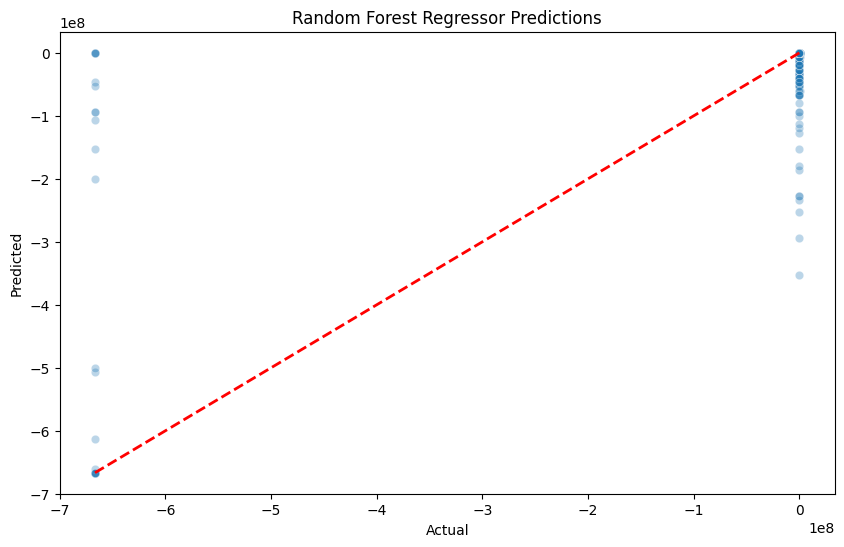

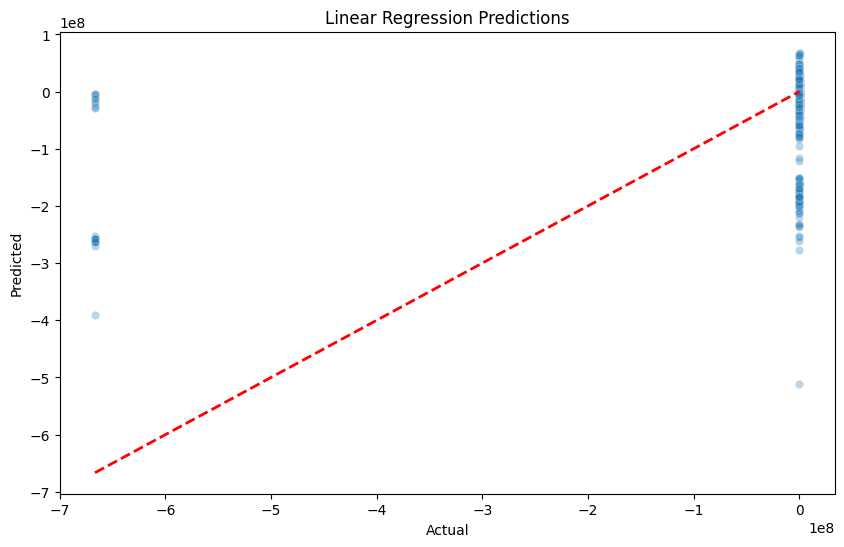

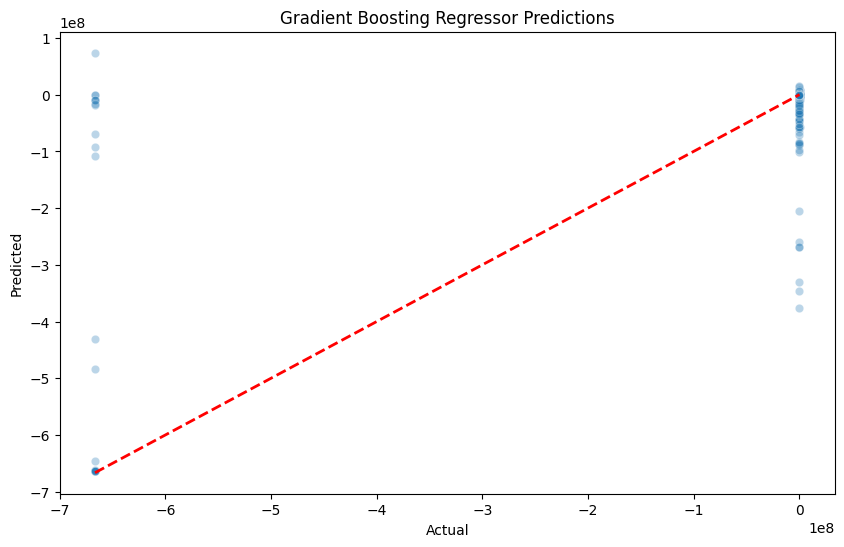

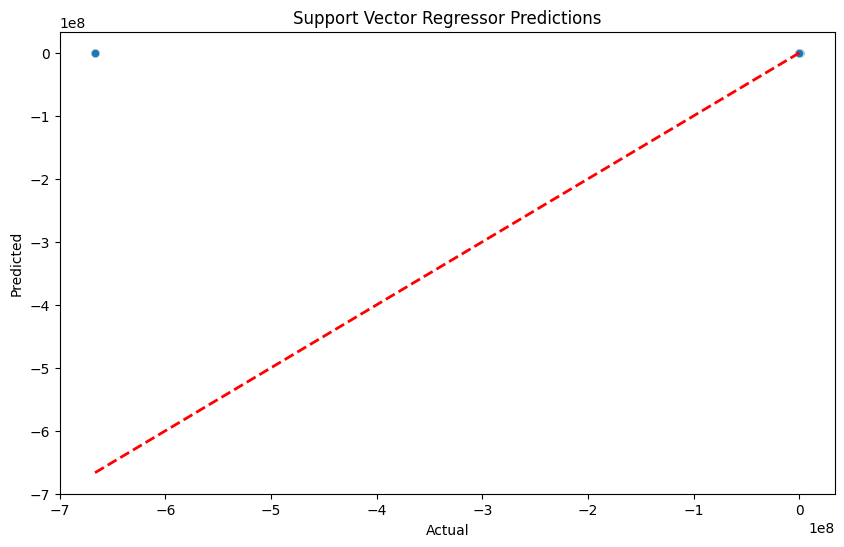

In [15]:
# Plotting function
def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Plot for Random Forest
plot_predictions(y_test, y_pred_rf, 'Random Forest Regressor Predictions')

# Plot for Linear Regression
plot_predictions(y_test, y_pred_lr, 'Linear Regression Predictions')

# Plot for Gradient Boosting Regressor
plot_predictions(y_test, y_pred_gbr, 'Gradient Boosting Regressor Predictions')

# Plot for Support Vector Regressor
plot_predictions(y_test, y_pred_svr, 'Support Vector Regressor Predictions')


## Step 5: Comparing Model Performance with Combined Plot

#### a. Filter out models with low R² scores

### Explanation:

1. **Model Training and Evaluation**:
   - Train and evaluate the models as before.
   - Store the predictions, RMSE, and R² scores in a DataFrame.

2. **Filtering Models**:
   - Filter out models with R² scores below a threshold (e.g., 0.5).
   - Adjust the threshold based on your specific requirements.

3. **Color Coding**:
   - Define a function to assign colors based on R² scores.
   - Green for strong models (R² >= 0.75), yellow for moderate models (0.5 <= R² < 0.75), and red for weak models (R² < 0.5).

4. **Combined Plot**:
   - Plot predictions of all remaining models on the same scatter plot.
   - Use different colors to indicate the strength of each model's predictions.

This approach is a better comparrison of the performance of different models visually, with color coding providing an intuitive indication of each model's strength.

/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


                      Model  \
0             Random Forest   
1         Linear Regression   
2         Gradient Boosting   
3  Support Vector Regressor   

                                         Predictions          RMSE        R2  
0  [-6559901.11, 86268.72, -33227808.91, 81320.77...  5.095196e+07  0.486323  
1  [-26760690.05856715, -5329176.622408681, -1158...  6.945089e+07  0.045615  
2  [-438959.19001466763, 529073.407906535, -19280...  5.443787e+07  0.413632  
3  [82277.86876545155, 82128.63475795195, 82150.7...  7.150256e+07 -0.011606  


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_20254/2734982049.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


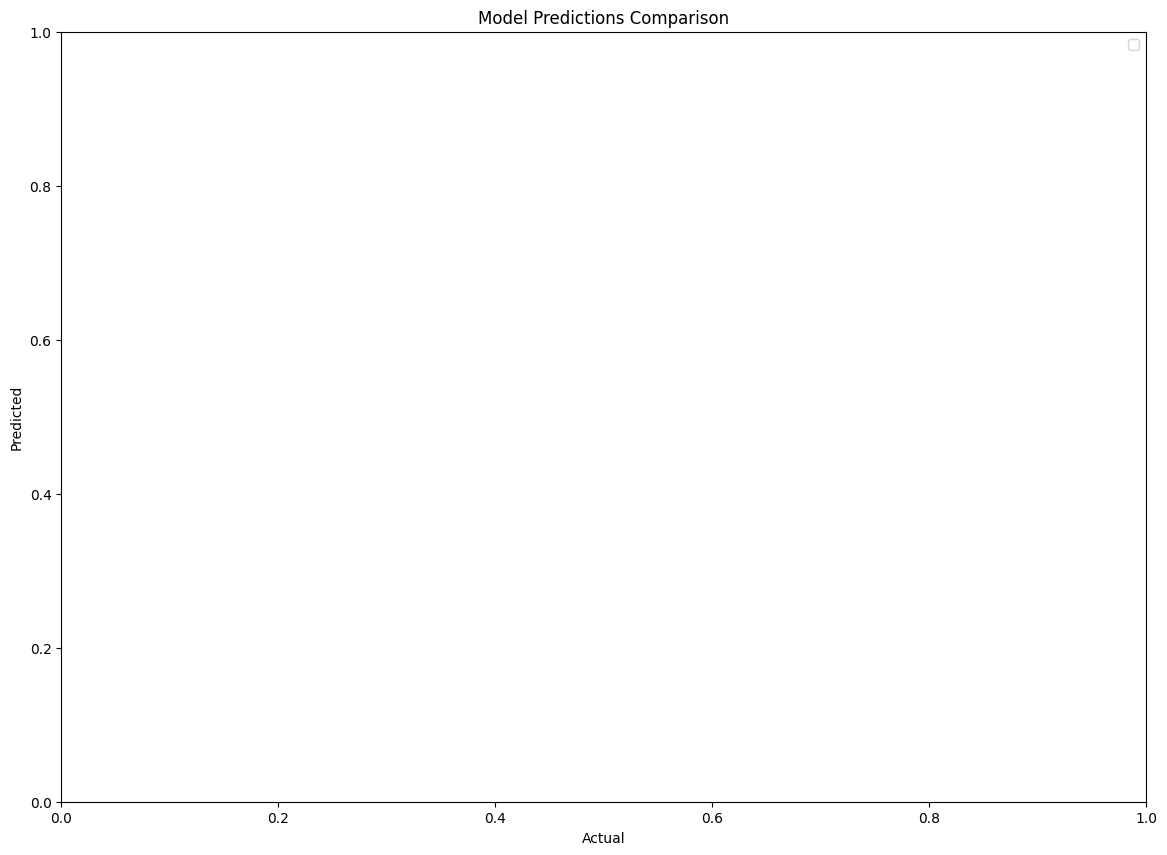

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('processed_acs_data.csv')

# Splitting the data
X = data.drop(columns=['median_household_income'])
y = data['median_household_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results.append((name, y_pred, rmse, r2))

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results, columns=['Model', 'Predictions', 'RMSE', 'R2'])
print(results_df)

# Filter out models with low R² scores
threshold = 0.5  # Adjust this threshold as needed
results_df = results_df[results_df['R2'] >= threshold]

# Define color codes based on R² scores
def get_color(r2):
    if r2 >= 0.75:
        return 'green'
    elif r2 >= 0.5:
        return 'yellow'
    else:
        return 'red'

results_df['Color'] = results_df['R2'].apply(get_color)

# Combined Plot
plt.figure(figsize=(14, 10))
for index, row in results_df.iterrows():
    sns.scatterplot(x=y_test, y=row['Predictions'], alpha=0.3, label=row['Model'], color=row['Color'])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Predictions Comparison')
plt.legend()
plt.show()

## Step 5 Plot Debugging
Let's troubleshoot and ensure the combined plot displays the data correctly. We'll check the intermediate steps to make sure the models are trained properly, and the predictions are being generated and filtered correctly.

Here's the updated script with additional print statements and corrections:

### Explanation of Debugging Steps:

1. **Debugging Print Statements**:
   - Added print statements after evaluating each model to display RMSE and R² scores.
   - Added print statements to display the `results_df` and `filtered_results_df` DataFrames.

2. **Check Filtered Data**:
   - Verify that the `filtered_results_df` DataFrame is not empty and contains the expected models after filtering.

3. **Ensure Plot Data Exists**:
   - The combined plot should display points if `filtered_results_df` contains valid predictions and R² scores.

Run the updated script to see the print statements' outputs and verify the data. This will help identify any issues in the filtering or plotting steps.

/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest: RMSE = 50951957.66851746, R2 = 0.48632317042373274
Linear Regression: RMSE = 69450885.73815444, R2 = 0.04561456246586604


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting: RMSE = 54437869.85428656, R2 = 0.4136317152939112
Support Vector Regressor: RMSE = 71502557.77707155, R2 = -0.011605964922559275
                      Model  \
0             Random Forest   
1         Linear Regression   
2         Gradient Boosting   
3  Support Vector Regressor   

                                         Predictions          RMSE        R2  
0  [-6559901.11, 86268.72, -33227808.91, 81320.77...  5.095196e+07  0.486323  
1  [-26760690.05856715, -5329176.622408681, -1158...  6.945089e+07  0.045615  
2  [-438959.19001466763, 529073.407906535, -19280...  5.443787e+07  0.413632  
3  [82277.86876545155, 82128.63475795195, 82150.7...  7.150256e+07 -0.011606  
Empty DataFrame
Columns: [Model, Predictions, RMSE, R2]
Index: []


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_20254/2514522880.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


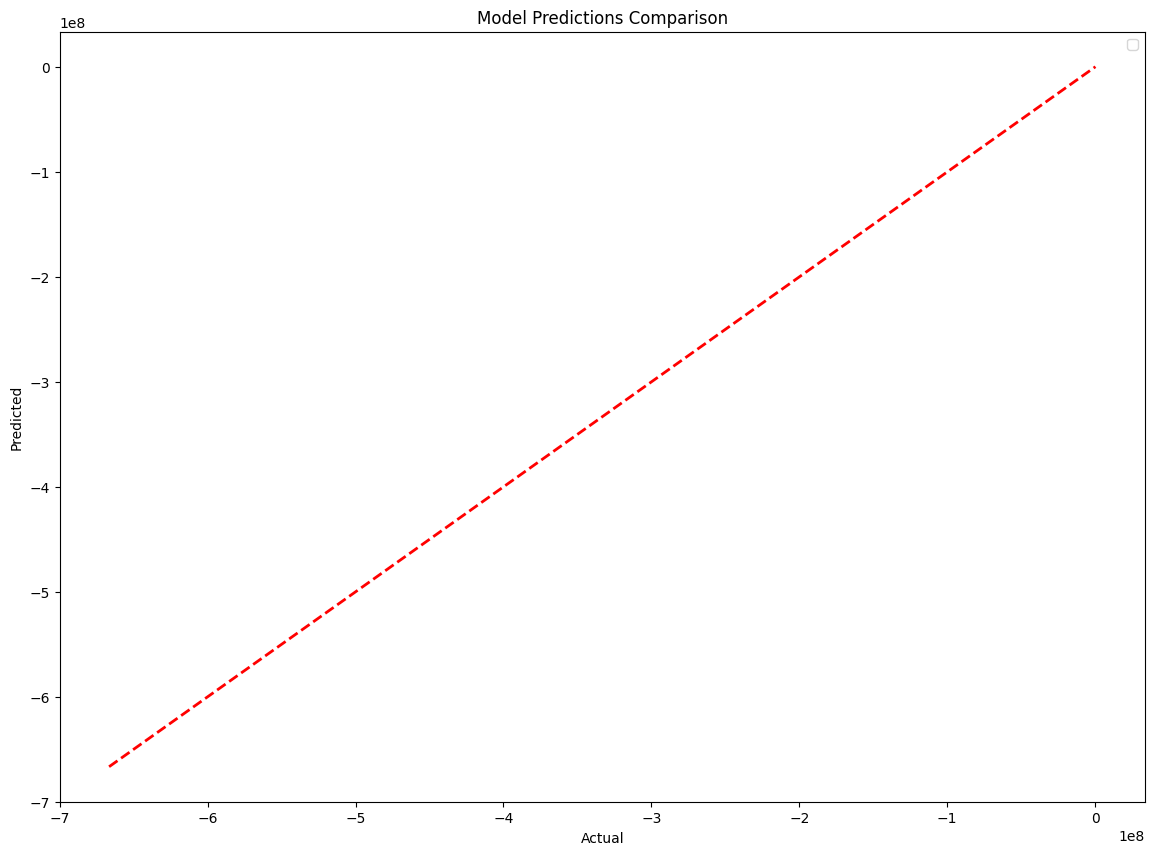

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('processed_acs_data.csv')

# Splitting the data
X = data.drop(columns=['median_household_income'])
y = data['median_household_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results.append((name, y_pred, rmse, r2))
    print(f'{name}: RMSE = {rmse}, R2 = {r2}')  # Debugging print statement

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results, columns=['Model', 'Predictions', 'RMSE', 'R2'])
print(results_df)  # Debugging print statement

# Filter out models with low R² scores
threshold = 0.5  # Adjust this threshold as needed
filtered_results_df = results_df[results_df['R2'] >= threshold]

print(filtered_results_df)  # Debugging print statement

# Define color codes based on R² scores
def get_color(r2):
    if r2 >= 0.75:
        return 'green'
    elif r2 >= 0.5:
        return 'yellow'
    else:
        return 'red'

filtered_results_df['Color'] = filtered_results_df['R2'].apply(get_color)

# Combined Plot
plt.figure(figsize=(14, 10))
for index, row in filtered_results_df.iterrows():
    sns.scatterplot(x=y_test, y=row['Predictions'], alpha=0.3, label=row['Model'], color=row['Color'])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Predictions Comparison')
plt.legend()
plt.show()


### The Issue identified
The issue is that after filtering, no models meet the threshold of an R² score of 0.5 or higher, resulting in an empty DataFrame. We should lower the threshold to include more models and adjust the plotting script accordingly.

## Part 6 updated script with a lower threshold
Here's the updated script with a lower threshold and ensuring the legend works correctly:

### Explanation of Changes:
1. **Lower Threshold**: Set `threshold` to 0.0 to include models with lower R² scores for comparison.
2. **Color Coding**: Retain the same color-coding logic.
3. **Plot Legend**: Ensure the legend displays correctly by specifying its location explicitly.

This approach includes more models for comparison and adjusts the color coding to reflect their performance.

/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest: RMSE = 50951957.66851746, R2 = 0.48632317042373274
Linear Regression: RMSE = 69450885.73815444, R2 = 0.04561456246586604


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting: RMSE = 54437869.85428656, R2 = 0.4136317152939112
Support Vector Regressor: RMSE = 71502557.77707155, R2 = -0.011605964922559275
                      Model  \
0             Random Forest   
1         Linear Regression   
2         Gradient Boosting   
3  Support Vector Regressor   

                                         Predictions          RMSE        R2  
0  [-6559901.11, 86268.72, -33227808.91, 81320.77...  5.095196e+07  0.486323  
1  [-26760690.05856715, -5329176.622408681, -1158...  6.945089e+07  0.045615  
2  [-438959.19001466763, 529073.407906535, -19280...  5.443787e+07  0.413632  
3  [82277.86876545155, 82128.63475795195, 82150.7...  7.150256e+07 -0.011606  
               Model                                        Predictions  \
0      Random Forest  [-6559901.11, 86268.72, -33227808.91, 81320.77...   
1  Linear Regression  [-26760690.05856715, -5329176.622408681, -1158...   
2  Gradient Boosting  [-438959.19001466763, 529073.407906535, -19280...   



/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_20254/884263635.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df['Color'] = filtered_results_df['R2'].apply(get_color)


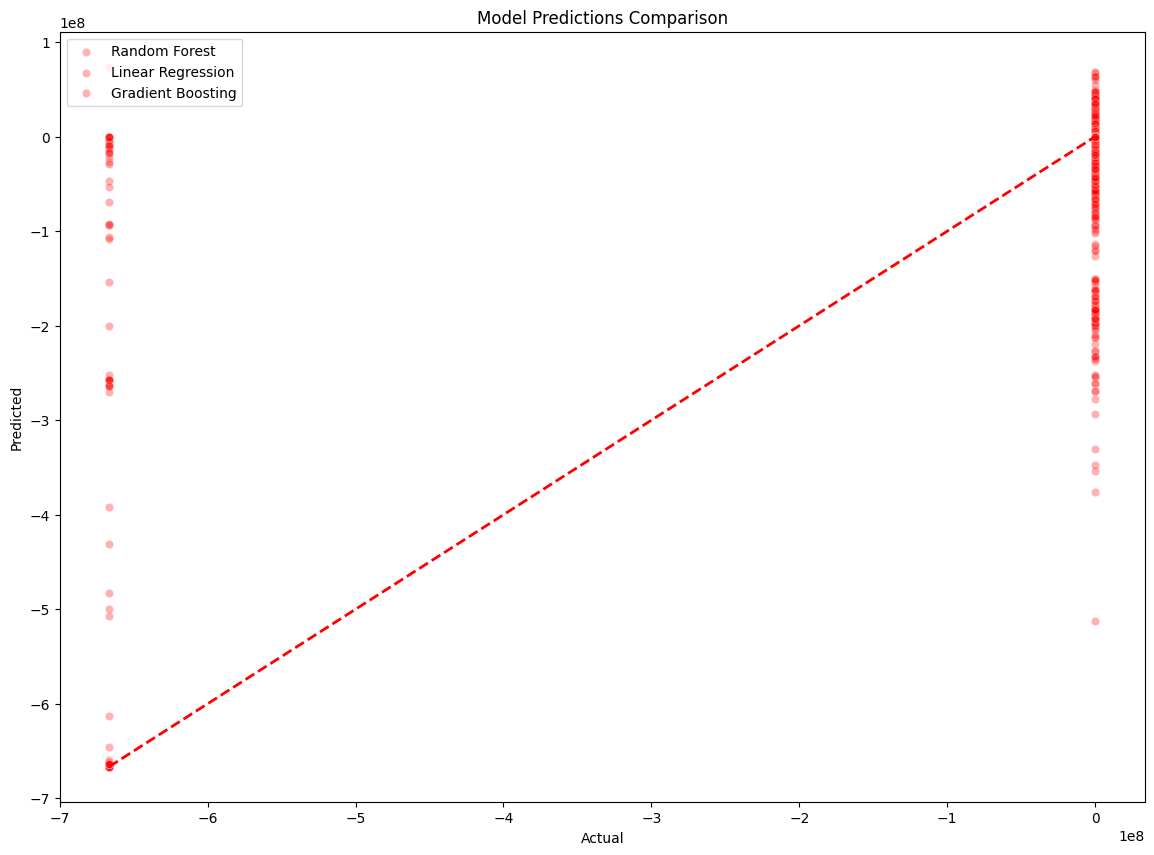

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
data = pd.read_csv('processed_acs_data.csv')

# Splitting the data
X = data.drop(columns=['median_household_income'])
y = data['median_household_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results.append((name, y_pred, rmse, r2))
    print(f'{name}: RMSE = {rmse}, R2 = {r2}')  # Debugging print statement

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results, columns=['Model', 'Predictions', 'RMSE', 'R2'])
print(results_df)  # Debugging print statement

# Lower the threshold to include more models
threshold = 0.0  # Adjust this threshold as needed
filtered_results_df = results_df[results_df['R2'] >= threshold]

print(filtered_results_df)  # Debugging print statement

# Define color codes based on R² scores
def get_color(r2):
    if r2 >= 0.75:
        return 'green'
    elif r2 >= 0.5:
        return 'yellow'
    else:
        return 'red'

filtered_results_df['Color'] = filtered_results_df['R2'].apply(get_color)

# Combined Plot
plt.figure(figsize=(14, 10))
for index, row in filtered_results_df.iterrows():
    sns.scatterplot(x=y_test, y=row['Predictions'], alpha=0.3, label=row['Model'], color=row['Color'])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Predictions Comparison')
plt.legend(loc='upper left')
plt.show()


## Part 7... Trying a new approach 

Given the low R² values and the indistinguishability in the plot, it's clear we need to improve our feature engineering process. Here are a few steps you can take to develop better features for the model:

1. Feature Interaction: Create new features by combining existing features (e.g., employment rate * educational attainment).

2. Normalization: Ensure all features are on a similar scale.

3. Dimensionality Reduction: Use techniques like PCA (Principal Component Analysis) to reduce the dimensionality of the data.

4. Domain Knowledge: Incorporate additional features based on domain knowledge that may impact median household income.

5. Removing Outliers: Identify and remove any outliers that may be skewing the model.

### Step 1: Feature Engineering and Data Pre-processing
We'll create new features and normalize the data to start.



In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('processed_acs_data.csv')

# Creating interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(data.drop(columns=['median_household_income']))

# Convert to DataFrame
interaction_df = pd.DataFrame(interaction_features, columns=poly.get_feature_names_out(data.drop(columns=['median_household_income']).columns))

# Combine with original data
data_combined = pd.concat([data['median_household_income'], interaction_df], axis=1)

# Handling missing values
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data_combined), columns=data_combined.columns)

# Normalizing/Standardizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed.drop(columns=['median_household_income']))

# Creating the final DataFrame
processed_data = pd.DataFrame(scaled_features, columns=data_imputed.drop(columns=['median_household_income']).columns)
processed_data['median_household_income'] = data_imputed['median_household_income']

# Splitting the data
X = processed_data.drop(columns=['median_household_income'])
y = processed_data['median_household_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the preprocessed data to CSV
processed_data.to_csv('enhanced_processed_acs_data.csv', index=False)


### Step 2: Re-train and Evaluate Models
This updated approach incorporates interaction features and scales the data, potentially improving the model performance. After running these steps, check the new R² scores and plots to see if there's any improvement.

/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest: RMSE = 54037352.399317235, R2 = 0.4222281866967339


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression: RMSE = 65901268.87516464, R2 = 0.140678298614896


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting: RMSE = 52652960.092397824, R2 = 0.4514530434234161
Support Vector Regressor: RMSE = 71502562.35740165, R2 = -0.011606094526018351
                      Model  \
0             Random Forest   
1         Linear Regression   
2         Gradient Boosting   
3  Support Vector Regressor   

                                         Predictions          RMSE        R2  
0  [101712.29, 87230.04, 107412.33, 87881.88, -13...  5.403735e+07  0.422228  
1  [-23713802.399424896, -6854666.399424894, -249...  6.590127e+07  0.140678  
2  [191687.66382365147, 191687.66382365147, -1569...  5.265296e+07  0.451453  
3  [82222.74994055687, 82229.11241762748, 82232.6...  7.150256e+07 -0.011606  
               Model                                        Predictions  \
0      Random Forest  [101712.29, 87230.04, 107412.33, 87881.88, -13...   
1  Linear Regression  [-23713802.399424896, -6854666.399424894, -249...   
2  Gradient Boosting  [191687.66382365147, 191687.66382365147, -1569...   


/Users/brock/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_20254/3827582127.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df['Color'] = filtered_results_df['R2'].apply(get_color)


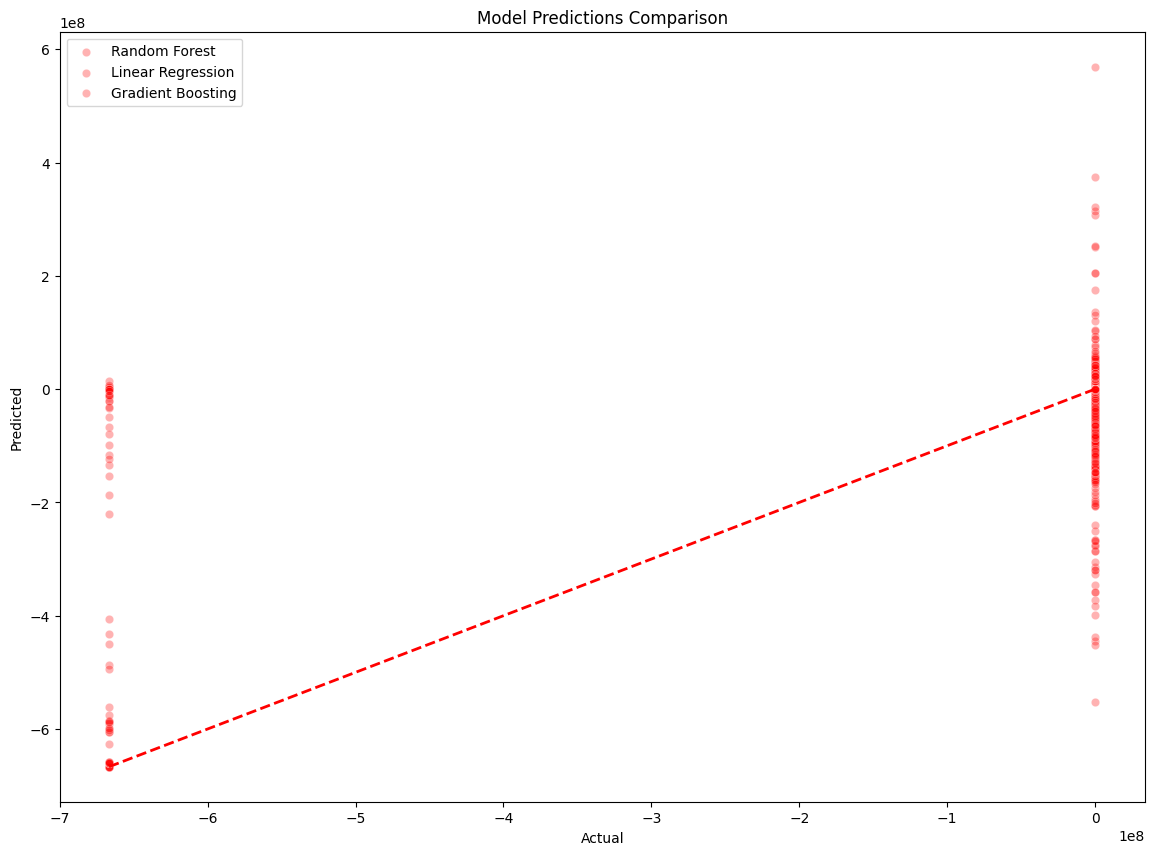

In [21]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the enhanced preprocessed data
data = pd.read_csv('enhanced_processed_acs_data.csv')

# Splitting the data
X = data.drop(columns=['median_household_income'])
y = data['median_household_income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results.append((name, y_pred, rmse, r2))
    print(f'{name}: RMSE = {rmse}, R2 = {r2}')  # Debugging print statement

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results, columns=['Model', 'Predictions', 'RMSE', 'R2'])
print(results_df)  # Debugging print statement

# Lower the threshold to include more models
threshold = 0.0  # Adjust this threshold as needed
filtered_results_df = results_df[results_df['R2'] >= threshold]

print(filtered_results_df)  # Debugging print statement

# Define color codes based on R² scores
def get_color(r2):
    if r2 >= 0.75:
        return 'green'
    elif r2 >= 0.5:
        return 'yellow'
    else:
        return 'red'

filtered_results_df['Color'] = filtered_results_df['R2'].apply(get_color)

# Combined Plot
plt.figure(figsize=(14, 10))
for index, row in filtered_results_df.iterrows():
    sns.scatterplot(x=y_test, y=row['Predictions'], alpha=0.3, label=row['Model'], color=row['Color'])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Predictions Comparison')
plt.legend(loc='upper left')
plt.show()


# New Direction

**prompt**
All the R^2 values were still terrible. Maybe this isn't going to work. There is a strong correlation between educational attainment and income. Was that feature used by itself, or is there a difference between the correlations where each population (eg high school diploma vs college degree) are statistically different (with low pval) and machine learning prediction? 

**Response**
Given the strong correlation between educational attainment and income, it makes sense to analyze this relationship more closely. We'll first check the correlations and statistical significance of different educational attainment levels with median household income. Then we'll see if the inclusion of these features alone (or combined) improves the model's performance.

## Step 1: Correlation and Statistical Significance Analysis
We'll calculate the correlation coefficients and perform hypothesis testing to determine the significance of the correlation between different educational attainment levels and median household income.


In [22]:
import pandas as pd
import scipy.stats as stats

# Load the preprocessed data
data = pd.read_csv('processed_acs_data.csv')

# Calculate correlation coefficients
correlation_matrix = data.corr()
education_columns = ['B15003_017E', 'B15003_018E', 'B15003_019E', 'B15003_020E', 
                     'B15003_021E', 'B15003_022E', 'B15003_023E', 'B15003_024E', 
                     'B15003_025E']

# Print correlation with median household income
for column in education_columns:
    correlation = correlation_matrix.loc[column, 'median_household_income']
    print(f'Correlation between {column} and median_household_income: {correlation}')

# Perform hypothesis testing to check statistical significance
for column in education_columns:
    corr, p_value = stats.pearsonr(data[column], data['median_household_income'])
    print(f'Correlation between {column} and median_household_income: {corr}, p-value: {p_value}')


KeyError: 'B15003_017E'

In [23]:
import pandas as pd

# Load the preprocessed data
data = pd.read_csv('processed_acs_data.csv')

# Print column names
print(data.columns)

Index(['state', 'county', 'tract', 'total_education_population',
       'high_school_diploma', 'B15003_018E', 'B15003_019E', 'B15003_020E',
       'B15003_021E', 'bachelor_degree', 'B15003_023E', 'B15003_024E',
       'B15003_025E', 'total_labor_force', 'labor_force_employed',
       'unemployment', 'total_population', 'male_population',
       'female_population', 'total_race_population', 'white_population',
       'black_population', 'B02001_004E', 'B02001_005E', 'B02001_006E',
       'B02001_007E', 'B02001_008E', 'median_home_value',
       'average_commute_time', 'total_industry_population', 'C24030_002E',
       'C24030_003E', 'C24030_004E', 'C24030_005E', 'C24030_006E',
       'C24030_007E', 'C24030_008E', 'C24030_009E', 'C24030_010E',
       'C24030_011E', 'C24030_012E', 'median_household_income'],
      dtype='object')


In [24]:
import pandas as pd
import scipy.stats as stats

# Load the preprocessed data
data = pd.read_csv('processed_acs_data.csv')

# Identify the correct column names for educational attainment and median household income
education_columns = ['high_school_diploma', 'B15003_018E', 'B15003_019E', 'B15003_020E', 
                     'B15003_021E', 'bachelor_degree', 'B15003_023E', 'B15003_024E', 
                     'B15003_025E']

# Calculate correlation coefficients
correlation_matrix = data.corr()

# Print correlation with median household income
for column in education_columns:
    if column in correlation_matrix.columns:
        correlation = correlation_matrix.loc[column, 'median_household_income']
        print(f'Correlation between {column} and median_household_income: {correlation}')

# Perform hypothesis testing to check statistical significance
for column in education_columns:
    if column in data.columns:
        corr, p_value = stats.pearsonr(data[column], data['median_household_income'])
        print(f'Correlation between {column} and median_household_income: {corr}, p-value: {p_value}')


Correlation between high_school_diploma and median_household_income: 0.13683064069963294
Correlation between B15003_018E and median_household_income: -0.0552758176398947
Correlation between B15003_019E and median_household_income: 0.10507156834450643
Correlation between B15003_020E and median_household_income: 0.13015039379668636
Correlation between B15003_021E and median_household_income: 0.14846394174854566
Correlation between bachelor_degree and median_household_income: 0.1488805336864287
Correlation between B15003_023E and median_household_income: 0.10464149861914637
Correlation between B15003_024E and median_household_income: 0.08563757804399562
Correlation between B15003_025E and median_household_income: 0.06641950614831749
Correlation between high_school_diploma and median_household_income: 0.1368306406996336, p-value: 2.1131835194558722e-39
Correlation between B15003_018E and median_household_income: -0.05527581763989474, p-value: 1.2591820446109822e-07
Correlation between B150

The correlations between the educational attainment levels and median household income, while statistically significant, are relatively low. The highest correlation is about 0.15 for bachelor_degree and B15003_021E, indicating a weak linear relationship. Given this, it's not surprising that the models may struggle to predict median household income accurately based on these features alone.



## This may require a lot more work, beyond the scope of this example. 

This is using the GPT to help with ideation:

## prompt 
It might be the driving forces and interactions could come from a lot of other factors. Don't proceed with evaluating or creating code, but comment on these thoughts by providing feedback: geography as is city or area, cost of living, age, and way more make prediction even more difficult

## response:
You're absolutely right. Predicting median household income is inherently complex and influenced by a myriad of factors that interact in non-linear ways. Here are some key considerations and thoughts on the complexities involved:

### Geographic Influence
- **City or Area**: Different cities and areas have varying economic conditions, employment opportunities, and social services that significantly impact household income. Urban areas typically have higher costs of living and incomes compared to rural areas.
- **Regional Economics**: The economic health of a region, including the presence of major industries, can strongly influence income levels. Areas with thriving industries or tech hubs may have higher median incomes.

### Cost of Living
- **Housing Costs**: Median household income needs to be adjusted for the cost of living to provide a more accurate picture. High-income areas often have high housing costs, which might offset the apparent income advantages.
- **General Cost of Living**: This includes not just housing, but also groceries, healthcare, education, and transportation. Differences in these costs can significantly impact disposable income and overall financial well-being.

### Demographics
- **Age Distribution**: Different age groups may have different income levels. Younger populations might have lower incomes due to entry-level jobs, whereas older populations might have higher incomes due to career advancement.
- **Household Size and Composition**: The number of earners in a household and the presence of dependents can influence median household income. Single-earner households versus dual-earner households will have different income dynamics.

### Socioeconomic Factors
- **Educational Attainment**: As you observed, higher educational attainment generally correlates with higher income. However, this relationship can vary widely based on the field of study and geographic location.
- **Employment and Occupation Types**: The type of employment (e.g., tech, manufacturing, service industry) and occupation can significantly impact income. Stable, high-paying industries lead to higher median incomes.
- **Unemployment Rates**: Areas with higher unemployment rates generally have lower median household incomes.

### Policy and Social Services
- **Government Policies**: Tax policies, minimum wage laws, and social services provided by local and federal governments can impact disposable income and overall economic health.
- **Social Safety Nets**: Availability and accessibility of social services such as healthcare, unemployment benefits, and food assistance can affect household income and financial stability.

### Cultural and Social Factors
- **Cultural Norms**: Cultural attitudes towards education, work, and savings can influence income levels. Some cultures might prioritize certain professions or industries, affecting income distribution.
- **Discrimination and Inequality**: Systemic issues such as racial and gender discrimination can lead to income disparities. Historical inequalities often translate into economic inequalities.

### Data Complexity
- **Data Quality and Availability**: High-quality, granular data is essential for accurate prediction. However, obtaining such data for all relevant factors can be challenging.
- **Non-linear Relationships**: Many of these factors interact in non-linear ways, making it difficult for traditional models to capture the true relationships without sophisticated feature engineering and model tuning.

### Advanced Modeling Techniques
- **Machine Learning Models**: Advanced models such as gradient boosting machines, neural networks, and ensemble methods can capture complex interactions better than traditional linear models.
- **Feature Engineering**: Creating meaningful interaction terms, combining features, and using domain knowledge to guide feature selection can significantly improve model performance.
- **Cross-Validation**: Ensuring the robustness of the models through techniques like cross-validation can help in assessing the true performance of the models.

### Conclusion
Predicting median household income accurately requires considering a wide array of factors, including geographic, socioeconomic, demographic, and policy-related influences. The interplay between these factors makes the problem complex, but with careful feature engineering and advanced modeling techniques, it is possible to capture some of these relationships. However, the inherent uncertainty and variability in human and economic behavior mean that perfect predictions are unlikely. Continuous refinement and incorporation of more diverse data sources can help improve the predictive accuracy over time.
